# Classify Fluorescence Images as Polarized

This notebook implements a basic CNN to classify fluorescent images of embryos as having or lacking polarized caps.

In [1]:
!pip install mxnet

In [2]:
from __future__ import print_function
import h5py
import mxnet as mx
from mxnet import gluon
from mxnet.gluon import nn
from mxnet import autograd as ag
import utils
import os
import numpy as np

# Fixing the random seed
mx.random.seed(42)

### Define Model

In [3]:
import mxnet.ndarray as F

class Net(gluon.Block):
    def __init__(self, **kwargs):
        super(Net, self).__init__(**kwargs)
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.conv1 = nn.Conv2D(20, kernel_size=(5,5))
            self.pool1 = nn.MaxPool2D(pool_size=(2,2), strides = (2,2))
            self.conv2 = nn.Conv2D(50, kernel_size=(5,5))
            self.pool2 = nn.MaxPool2D(pool_size=(2,2), strides = (2,2))
            self.fc1 = nn.Dense(500)
            self.fc2 = nn.Dense(10)

    def forward(self, x):
        x = self.pool1(F.tanh(self.conv1(x)))
        x = self.pool2(F.tanh(self.conv2(x)))
        # 0 means copy over size from corresponding dimension.
        # -1 means infer size from the rest of dimensions.
        x = x.reshape((0, -1))
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [4]:
net = Net()

### Data Preprocessing

In [5]:
# preprocess the data
fluo_data_path = "../data/video_fluo_data"
embryo_idx = 46
fluo = h5py.File(os.path.join(fluo_data_path,'embryo_'+str(embryo_idx)+'.mat'))
arrays = {}
for k, v in fluo.items():
    arrays[k] = np.array(v)

fluo_video = arrays['data']
pol_state = arrays['anno']

# a bit of data processing... get middle z slice
fluo_video = np.array([utils.get_middle_z(fluo_video)])
fluo_video = np.moveaxis(fluo_video, -1, 0)

# # train-test split
# from sklearn.model_selection import train_test_split
# # split 0.2 for test set
# X_train, X_test, y_train, y_test = train_test_split(fluo_video, pol_state[0], test_size=0.2, random_state=42)
# # split 0.2 for val set
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# # keep 0.6 for train set

### Data Loaders

In [6]:
# # define the batch size for data loading
# batch_size = 30

# # data loaders?
# # iterator vs dataloader: https://mxnet.apache.org/versions/1.7/api/python/docs/tutorials/packages/gluon/data/datasets.html#Appendix:-Upgrading-from-Module-DataIter-to-Gluon-DataLoader
# # dataloader: https://mxnet.apache.org/versions/1.7/api/python/docs/tutorials/packages/gluon/data/datasets.html
# # data iterator: https://mxnet.apache.org/versions/1.1.0/tutorials/basic/data.html
# train_data = mx.io.NDArrayIter(X_train, y_train, batch_size=batch_size, shuffle=True)
# test_data = mx.io.NDArrayIter(X_test, y_test, batch_size=batch_size)
# val_data = mx.io.NDArrayIter(X_val, y_val, batch_size=batch_size)
# # # Convert to dataloader:
# # data_iter_loader = DataIterLoader(data_iter)
# # for X_batch, y_batch in data_iter_loader:

In [7]:
# define the batch size for data loading
batch_size = 30

train_data = mx.io.NDArrayIter(fluo_video, pol_state[0], batch_size=batch_size, shuffle=True)

### Optimizer, Metrics, Trainer

In [8]:
# set the context on GPU is available otherwise CPU
ctx = [mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()]
net.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

# For training
# Use Accuracy as the evaluation metric.
metric = mx.metric.Accuracy()
softmax_cross_entropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()

# For validation/test
# define an evaluation function for validation and testing
def test(net, test_data, ctx):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(test_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)
    return metric.get()

# learning rate
lr = 0.001
# lr_factor = 0.75 # Learning rate decay factor
# lr_steps = [10, 20, 30, np.inf] # Epochs where learning rate decays
wd = 0.0001
momentum = 0.0
optimizer = 'sgd' # 'nag': Nesterov accelerated gradient descent
optimizer_params = {'learning_rate': lr, 'wd': wd, 'momentum': momentum} # Set parameters
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

### Training Loop

In [9]:
epochs = 10

# lr_lst = [0.001, 0.005, 0.01, 0.05, 0.1]
# low learning rate, high momentum
lr_lst = [0.02]

train_acc_over_hyperparam_tensor = []
# val_acc_over_hyperparam_tensor = []

for lr_val in lr_lst:
    # set learning rate
    trainer.set_learning_rate(lr_val)
    
    # store results
    train_acc_lst = np.zeros(epochs)
#     val_acc_lst = np.zeros(epochs)

    for i in range(epochs):
        # Reset the train data iterator.
        train_data.reset()
        # Loop over the train data iterator.
        for batch in train_data:
            # Splits train data into multiple slices along batch_axis
            # and copy each slice into a context.
            data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
            # Splits train labels into multiple slices along batch_axis
            # and copy each slice into a context.
            label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
            outputs = []
            # Inside training scope
            with ag.record():
                for x, y in zip(data, label):
                    z = net(x)
                    # Computes softmax cross entropy loss.
                    loss = softmax_cross_entropy_loss(z, y)
                    # Backpropogate the error for one iteration.
                    loss.backward()
                    outputs.append(z)

            print(outputs)
            # Updates internal evaluation
            metric.update(label, outputs)
            # Make one step of parameter update. Trainer needs to know the
            # batch size of data to normalize the gradient by 1/batch_size.
            trainer.step(batch.data[0].shape[0])

        # Gets the training evaluation result.
        name, train_acc = metric.get()
        train_acc_lst[i] = train_acc

    #     # Gets the validation evaluation result.
    #     name, val_acc = test(net,val_data,ctx)
    #     val_acc_lst[i] = val_acc

        # Reset evaluation result to initial state.
        metric.reset()
        print('training acc at epoch %d: %s=%f'%(i, name, train_acc))
    
    train_acc_over_hyperparam_tensor.append(train_acc_lst)
#     val_acc_over_hyperparam_tensor.append(val_acc_lst)

[
[[ 0.4027144  -0.3358116   0.19056518 -0.29455036 -0.21242803 -0.2171781
  -0.52781236 -0.04942893 -0.3094047  -0.05660508]
 [ 0.53011316 -0.63680214 -0.39182144 -0.09116478 -0.7164045  -0.08754303
  -0.4396961  -0.1586413  -0.14806099 -0.26395816]
 [ 0.06284894 -0.44819075 -0.07256185 -0.4588292  -0.5458534  -0.37209377
  -0.5403874  -0.3249575   0.21480331 -0.1048461 ]
 [ 0.20850633 -0.20633858  0.06297897 -0.2435733  -0.25975066 -0.3067129
  -0.52038765 -0.16739579 -0.28902507 -0.60237366]
 [ 0.57742804 -0.51305705  0.168346   -0.10987832 -0.56131077 -0.21967039
  -0.4721991  -0.3952559  -0.05867163 -0.5775438 ]
 [ 0.1710422  -0.5260894   0.20846021  0.0779351  -0.34675062 -0.11367808
  -0.11450924 -0.28892437 -0.4174337  -0.31881067]
 [ 0.08692427 -0.70103496 -0.00814382  0.01924912 -0.3508587  -0.20235853
  -0.52986264 -0.342671    0.12113825 -0.49495983]
 [ 0.5137457  -0.57089025 -0.31584543 -0.3257418  -0.5974002   0.02869307
  -0.46210766 -0.4707121   0.3337852  -0.3933422 ]


training acc at epoch 2: accuracy=0.833333
[
[[ 1.          0.9966996  -0.99922305 -0.9987101  -0.99829805 -0.9489021
  -0.9809279  -0.9681781  -0.9864141  -0.9982822 ]
 [ 1.          0.99638635 -0.99918604 -0.9986378  -0.9981081  -0.94912606
  -0.98086816 -0.9702233  -0.98631096 -0.99834985]
 [ 1.          0.9961256  -0.99928296 -0.99870104 -0.9982417  -0.9511576
  -0.9799998  -0.9685837  -0.9865723  -0.9984822 ]
 [ 1.          0.9967389  -0.9992389  -0.99871665 -0.99830323 -0.94721186
  -0.98108596 -0.9675309  -0.9862244  -0.9982488 ]
 [ 1.          0.9967984  -0.9991913  -0.9986683  -0.99822575 -0.9479807
  -0.98077    -0.9684332  -0.98649204 -0.99821854]
 [ 1.          0.9965881  -0.99917406 -0.99868196 -0.99818254 -0.95011777
  -0.9810288  -0.9692138  -0.9869375  -0.9983109 ]
 [ 1.          0.99707574 -0.9992133  -0.99874806 -0.9981826  -0.9490553
  -0.9818847  -0.96998745 -0.9867773  -0.9983274 ]
 [ 1.          0.9967001  -0.9992172  -0.9986784  -0.99823344 -0.94977057
  -0.98117

training acc at epoch 5: accuracy=0.833333
[
[[ 1.          0.99317515 -0.9991286  -0.99846625 -0.99784625 -0.97044706
  -0.9795389  -0.9781106  -0.9880768  -0.99875593]
 [ 1.          0.9947343  -0.9991909  -0.9985592  -0.9979984  -0.96582127
  -0.9817671  -0.9767409  -0.9876011  -0.998574  ]
 [ 1.          0.99883795 -0.9994588  -0.9992672  -0.9986752  -0.9766773
  -0.9824077  -0.9832479  -0.9914651  -0.99841714]
 [ 1.          0.9941195  -0.9991355  -0.99846935 -0.9979318  -0.96857715
  -0.98015445 -0.97730696 -0.98865914 -0.998758  ]
 [ 1.          0.993283   -0.9991105  -0.99833274 -0.99774355 -0.96961194
  -0.98042166 -0.97862417 -0.9882331  -0.9987371 ]
 [ 1.          0.99331844 -0.9990799  -0.99833965 -0.99775726 -0.9680122
  -0.9802989  -0.97811973 -0.98722696 -0.99861944]
 [ 1.          0.99285173 -0.99908143 -0.9983997  -0.99773735 -0.9688597
  -0.97982943 -0.9787276  -0.98783356 -0.9987479 ]
 [ 1.          0.994534   -0.9991623  -0.9985329  -0.9979677  -0.9674815
  -0.98142

training acc at epoch 8: accuracy=0.866667
[
[[ 1.          0.9872096  -0.99898654 -0.998319   -0.9975932  -0.9750198
  -0.98277897 -0.9835686  -0.98897624 -0.9988359 ]
 [ 1.          0.9876999  -0.99902135 -0.99834085 -0.9976903  -0.97617155
  -0.9810323  -0.9833106  -0.9888822  -0.99890083]
 [ 1.          0.9856103  -0.9989652  -0.9982856  -0.9976595  -0.9759495
  -0.9807581  -0.9834216  -0.98834354 -0.9988916 ]
 [ 1.          0.9844694  -0.9989448  -0.9983494  -0.9976643  -0.97678417
  -0.9801085  -0.9841886  -0.988521   -0.99900204]
 [ 1.          0.9869285  -0.9990927  -0.99838877 -0.9976021  -0.97574514
  -0.9822243  -0.9840457  -0.98894644 -0.99897546]
 [ 1.          0.98526007 -0.99899983 -0.9984037  -0.99772984 -0.9773901
  -0.98027027 -0.9837161  -0.9888641  -0.9989929 ]
 [ 1.          0.98943293 -0.9991067  -0.9984667  -0.99752903 -0.9753351
  -0.98373586 -0.98472667 -0.9889912  -0.99891585]
 [ 1.          0.98617697 -0.9990178  -0.9982938  -0.99766594 -0.9767969
  -0.981102

### Plot Results

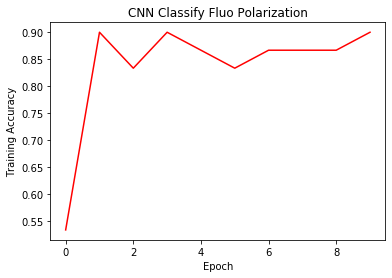

In [11]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.arange(0,epochs,1),train_acc_over_hyperparam_tensor[0],'r')
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.title('CNN Classify Fluo Polarization')
plt.show()